# Assignment 4: Chatbot
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>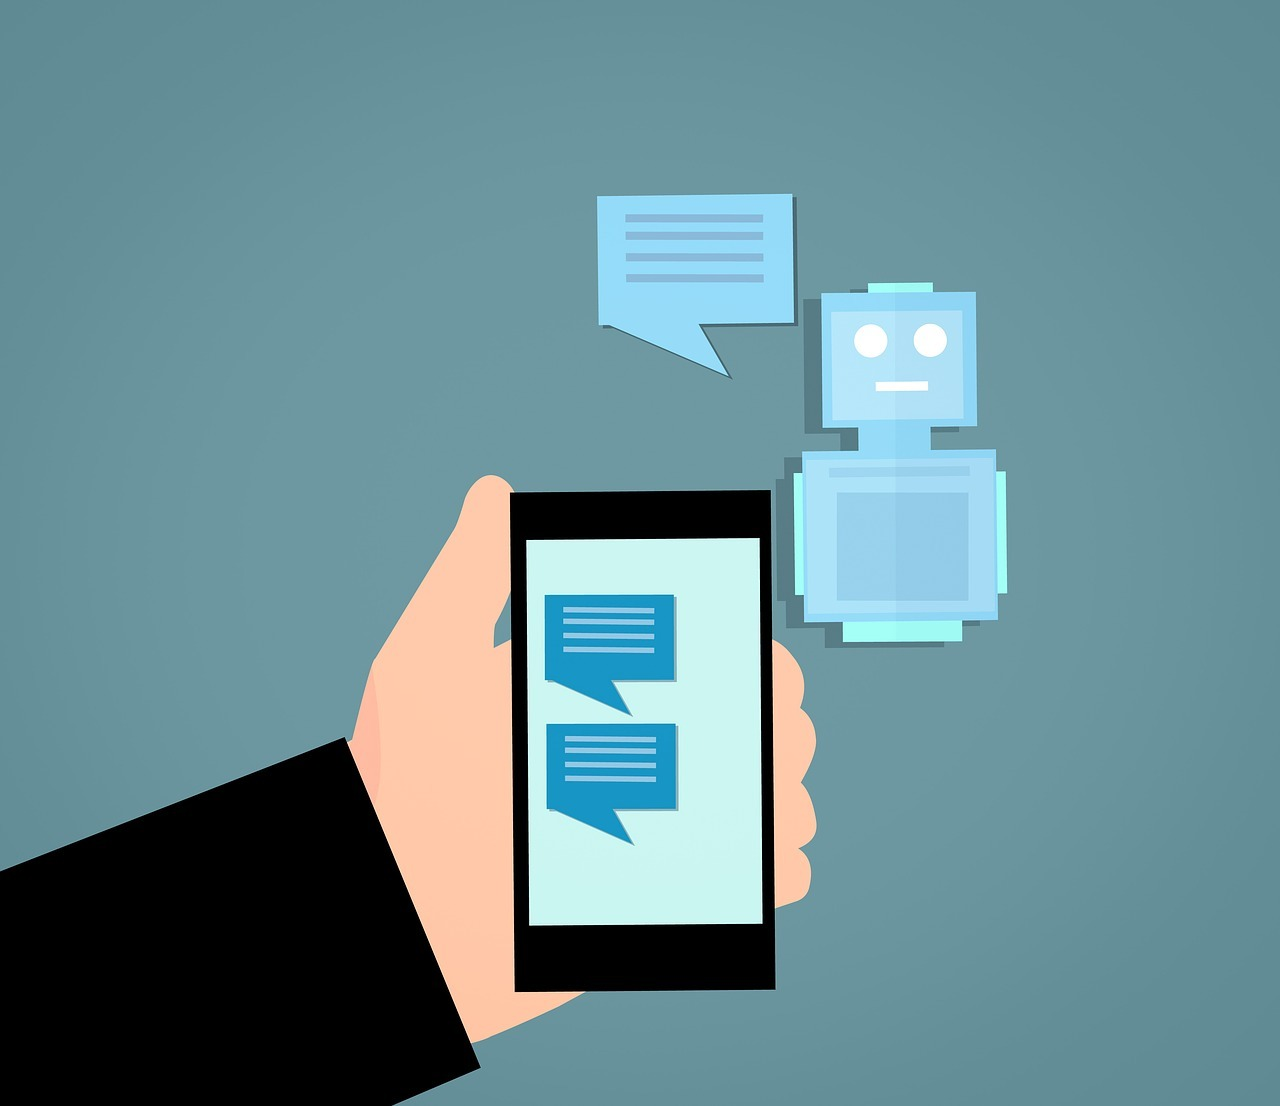</body></html>
<img src = "images/cbot.jpg" height="400" width="400"> 

Welcome to the last assignment of Course 4. Before you get started, we want to congratulate you on getting here. It is your 16th programming assignment in this Specialization and we are very proud of you! In this assignment, you are going to use the [Reformer](https://arxiv.org/abs/2001.04451), also known as the efficient Transformer, to generate a dialogue between two bots. You will feed conversations to your model and it will learn how to understand the context of each one. Not only will it learn how to answer questions but it will also know how to ask questions if it needs more info. For example, after a customer asks for a train ticket, the chatbot can ask what time the said customer wants to leave. You can use this concept to automate call centers, hotel receptions, personal trainers, or any type of customer service. By completing this assignment, you will:

* Understand how the Reformer works
* Explore the [MultiWoz](https://arxiv.org/abs/1810.00278) dataset
* Process the data to feed it into the model
* Train your model
* Generate a dialogue by feeding a question to the model


## Outline
- [Part 1:   Exploring the MultiWoz dataset](#1)
	- [Exercise 01](#ex01)
- [Part 2:   Processing the data for Reformer inputs](#2)
    - [2.1   Tokenizing, batching with bucketing](#2.1)
- [Part 3:   Reversible layers](#3)
	- [Exercise 02](#ex02)
	- [Exercise 03](#ex03)
    - [3.1   Reversible layers and randomness](#3.1)
- [Part 4:   ReformerLM Training](#4)
	- [Exercise 04](#ex04)
	- [Exercise 05](#ex05)
- [Part 5:   Decode from a pretrained model](#5)
	- [Exercise 06](#ex06)


<a name="1"></a>
# Part 1:   Exploring the MultiWoz dataset

You will start by exploring the MultiWoz dataset. The dataset you are about to use has more than 10,000 human annotated dialogues and spans multiple domains and topics. Some dialogues include multiple domains and others include single domains. In this section, you will load and explore this dataset, as well as develop a function to extract the dialogues.

Let's first import the modules we will be using:

In [16]:
import json
import random
import numpy as np
from termcolor import colored

import trax   
from trax import layers as tl
from trax.supervised import training

import w4_unittest

!pip list | grep trax

trax                         1.3.9
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


Let's also declare some constants we will be using in the exercises.

In [17]:
# filename of the MultiWOZ dialogue dataset
DATA_FILE = 'data.json'

# data directory
DATA_DIR = './data'

# dictionary where we will load the dialogue dataset
DIALOGUE_DB = {}

# vocabulary filename
VOCAB_FILE = 'en_32k.subword'

# vocabulary file directory
VOCAB_DIR = 'data/vocabs'

Let's now load the MultiWOZ 2.1 dataset. We have already provided it for you in your workspace. It is in JSON format so we should load it as such:

In [18]:
# help function to load a JSON file
def load_json(directory, file):
    with open(f'{directory}/{file}') as file: 
        db = json.load(file)
    return db

# load the dialogue data set into our dictionary
DIALOGUE_DB = load_json(DATA_DIR, DATA_FILE)

Let's see how many dialogues we have in the dictionary. 1 key-value pair is one dialogue so we can just get the dictionary's length.

In [19]:
print(f'The number of dialogues is: {len(DIALOGUE_DB)}')

The number of dialogues is: 10438


The dialogues are composed of multiple files and the filenames are used as keys in our dictionary. Those with multi-domain dialogues have "MUL" in their filenames while single domain dialogues have either "SNG" or "WOZ".

In [20]:
# print 7 keys from the dataset to see the filenames
print(list(DIALOGUE_DB.keys())[0:7]) 

['SNG01856.json', 'SNG0129.json', 'PMUL1635.json', 'MUL2168.json', 'SNG0073.json', 'SNG01445.json', 'MUL2105.json']


As you can see from the cells above, there are 10,438 conversations, each in its own file.  You will train your model on all those conversations. Each file is also loaded into a dictionary and each has two keys which are the following:

In [21]:
# get keys of the fifth file in the list above
print(DIALOGUE_DB['SNG0073.json'].keys())

dict_keys(['goal', 'log'])


The `goal` also points to a dictionary and it contains several keys pertaining to the objectives of the conversation. For example below, we can see that the conversation will be about booking a taxi.

In [22]:
DIALOGUE_DB['SNG0073.json']['goal']

{'taxi': {'info': {'leaveAt': '17:15',
   'destination': 'pizza hut fen ditton',
   'departure': "saint john's college"},
  'reqt': ['car type', 'phone'],
  'fail_info': {}},
 'police': {},
 'hospital': {},
 'hotel': {},
 'attraction': {},
 'train': {},
 'message': ["You want to book a <span class='emphasis'>taxi</span>. The taxi should go to <span class='emphasis'>pizza hut fen ditton</span> and should depart from <span class='emphasis'>saint john's college</span>",
  "The taxi should <span class='emphasis'>leave after 17:15</span>",
  "Make sure you get <span class='emphasis'>car type</span> and <span class='emphasis'>contact number</span>"],
 'restaurant': {}}

The `log` on the other hand contains the dialog. It is a list of dictionaries and each element of this list contains several descriptions as well. Let's look at an example:

In [23]:
# get first element of the log list
DIALOGUE_DB['SNG0073.json']['log'][0]

{'text': "I would like a taxi from Saint John's college to Pizza Hut Fen Ditton.",
 'metadata': {},
 'dialog_act': {'Taxi-Inform': [['Dest', 'pizza hut fen ditton'],
   ['Depart', "saint john 's college"]]},
 'span_info': [['Taxi-Inform', 'Dest', 'pizza hut fen ditton', 11, 14],
  ['Taxi-Inform', 'Depart', "saint john 's college", 6, 9]]}

For this assignment, we are only interested in the conversation which is in the `text` field.
The conversation goes back and forth between two persons. Let's call them 'Person 1' and 'Person 2'. This implies that
data['SNG0073.json']['log'][0]['text'] is 'Person 1' and
data['SNG0073.json']['log'][1]['text'] is 'Person 2' and so on. The even offsets are 'Person 1' and the odd offsets are 'Person 2'.

In [24]:
print(' Person 1: ', DIALOGUE_DB['SNG0073.json']['log'][0]['text'])
print(' Person 2: ',DIALOGUE_DB['SNG0073.json']['log'][1]['text'])

 Person 1:  I would like a taxi from Saint John's college to Pizza Hut Fen Ditton.
 Person 2:  What time do you want to leave and what time do you want to arrive by?


<a name="ex01"></a>
### Exercise 01

You will now implement the `get_conversation()` function that will extract the conversations from the dataset's file.

**Instructions:** Implement a function to extract conversations from the input file.   
As described above, the conversation is in the `text` field in each of the elements in the `log` list of the file. If the log list has `x` number of elements, then the function will get the `text` entries of each of those elements. Your function should return the conversation, prepending each field with either ' Person 1: ' if 'x' is even or ' Person 2: ' if 'x' is odd. You can use the Python modulus operator '%' to help select the even/odd entries. Important note: Do not print a newline character (i.e. `\n`) when generating the string. For example, in the code cell above, your function should output something like:

```
 Person 1: I would like a taxi from Saint John's college to Pizza Hut Fen Ditton. Person 2: What time do you want to leave and what time do you want to arrive by?
```

and **not**:

```
 Person 1:  I would like a taxi from Saint John's college to Pizza Hut Fen Ditton.
 Person 2:  What time do you want to leave and what time do you want to arrive by?
```

In [25]:
# UNQ_C1
# GRADED FUNCTION: get_conversation
def get_conversation(file, data_db):
    '''
    Args:
        file (string): filename of the dialogue file saved as json
        data_db (dict): dialogue database
    
    Returns:
        string: A string containing the 'text' fields of  data[file]['log'][x]
    '''
    
    # initialize empty string
    result = ''
    
    # get length of file's log list
    len_msg_log = len(data_db[file]['log'])
    
    # set the delimiter strings
    delimiter_1 = ' Person 1: '
    delimiter_2 = ' Person 2: '
    
    # loop over the file's log list
    for i in range(len_msg_log):
        
    ### START CODE HERE ###
    
        # get i'th element of file log list
        cur_log = data_db[file]['log'][i]
        
        # check if i is even
        if i%2==0:
            # append the 1st delimiter string
            result += delimiter_1 
        else: 
            # append the 2nd delimiter string
            result += delimiter_2
        
        # append the message text from the log
        result += cur_log['text']
    
    ### END CODE HERE ###

    return result

In [26]:
# BEGIN UNIT TEST
w4_unittest.test_get_conversation(get_conversation)
# END UNIT TEST

 All tests passed


In [27]:
file = 'SNG01856.json'
conversation = get_conversation(file, DIALOGUE_DB)

# print raw output
print(conversation)

 Person 1: am looking for a place to to stay that has cheap price range it should be in a type of hotel Person 2: Okay, do you have a specific area you want to stay in? Person 1: no, i just need to make sure it's cheap. oh, and i need parking Person 2: I found 1 cheap hotel for you that includes parking. Do you like me to book it? Person 1: Yes, please. 6 people 3 nights starting on tuesday. Person 2: I am sorry but I wasn't able to book that for you for Tuesday. Is there another day you would like to stay or perhaps a shorter stay? Person 1: how about only 2 nights. Person 2: Booking was successful.
Reference number is : 7GAWK763. Anything else I can do for you? Person 1: No, that will be all. Good bye. Person 2: Thank you for using our services.


**Expected Result:**
```
Person 1: am looking for a place to to stay that has cheap price range it should be in a type of hotel Person 2: Okay, do you have a specific area you want to stay in? Person 1: no, i just need to make sure it's cheap. oh, and i need parking Person 2: I found 1 cheap hotel for you that includes parking. Do you like me to book it? Person 1: Yes, please. 6 people 3 nights starting on tuesday. Person 2: I am sorry but I wasn't able to book that for you for Tuesday. Is there another day you would like to stay or perhaps a shorter stay? Person 1: how about only 2 nights. Person 2: Booking was successful.
Reference number is : 7GAWK763. Anything else I can do for you? Person 1: No, that will be all. Good bye. Person 2: Thank you for using our services.
```

We can have a utility pretty print function just so we can visually follow the conversation more easily.

In [28]:
def print_conversation(conversation):
    
    delimiter_1 = 'Person 1: '
    delimiter_2 = 'Person 2: '
    
    split_list_d1 = conversation.split(delimiter_1)
    
    for sublist in split_list_d1[1:]:
        split_list_d2 = sublist.split(delimiter_2)
        print(colored(f'Person 1: {split_list_d2[0]}', 'red'))
        
        if len(split_list_d2) > 1:
            print(colored(f'Person 2: {split_list_d2[1]}', 'green'))

            
print_conversation(conversation)

Person 1: am looking for a place to to stay that has cheap price range it should be in a type of hotel 
Person 2: Okay, do you have a specific area you want to stay in? 
Person 1: no, i just need to make sure it's cheap. oh, and i need parking 
Person 2: I found 1 cheap hotel for you that includes parking. Do you like me to book it? 
Person 1: Yes, please. 6 people 3 nights starting on tuesday. 
Person 2: I am sorry but I wasn't able to book that for you for Tuesday. Is there another day you would like to stay or perhaps a shorter stay? 
Person 1: how about only 2 nights. 
Person 2: Booking was successful.
Reference number is : 7GAWK763. Anything else I can do for you? 
Person 1: No, that will be all. Good bye. 
Person 2: Thank you for using our services.


For this assignment, we will just use the outputs of the calls to `get_conversation` to train the model. But just to expound, there are also other information in the MultiWoz dataset that can be useful in other contexts. Each element of the log list has more information about it. For example, above, if you were to look at the other fields for the following, "am looking for a place to stay that has cheap price range it should be in a type of hotel", you will get the following. 

In [29]:
DIALOGUE_DB['SNG01856.json']['log'][0]

{'text': 'am looking for a place to to stay that has cheap price range it should be in a type of hotel',
 'metadata': {},
 'dialog_act': {'Hotel-Inform': [['Type', 'hotel'], ['Price', 'cheap']]},
 'span_info': [['Hotel-Inform', 'Type', 'hotel', 20, 20],
  ['Hotel-Inform', 'Price', 'cheap', 10, 10]]}

The dataset also comes with hotel, hospital, taxi, train, police, and restaurant databases. For example, in case you need to call a doctor, or a hotel, or a taxi, this will allow you to automate the entire conversation. Take a look at the files accompanying the data set.

In [30]:
# this is an example of the attractions file
attraction_file = open('data/attraction_db.json')
attractions = json.load(attraction_file)
print(attractions[0])

{'address': 'pool way, whitehill road, off newmarket road', 'area': 'east', 'entrance fee': '?', 'id': '1', 'location': [52.208789, 0.154883], 'name': 'abbey pool and astroturf pitch', 'openhours': '?', 'phone': '01223902088', 'postcode': 'cb58nt', 'pricerange': '?', 'type': 'swimmingpool'}


In [31]:
# this is an example of the hospital file
hospital_file = open('data/hospital_db.json')
hospitals = json.load(hospital_file)
print(hospitals[0]) # feel free to index into other indices

{'department': 'neurosciences critical care unit', 'id': 0, 'phone': '01223216297'}


In [32]:
# this is an example of the hotel file
hotel_file = open('data/hotel_db.json')
hotels = json.load(hotel_file)
print(hotels[0]) # feel free to index into other indices

{'address': '124 tenison road', 'area': 'east', 'internet': 'yes', 'parking': 'no', 'id': '0', 'location': [52.1963733, 0.1987426], 'name': 'a and b guest house', 'phone': '01223315702', 'postcode': 'cb12dp', 'price': {'double': '70', 'family': '90', 'single': '50'}, 'pricerange': 'moderate', 'stars': '4', 'takesbookings': 'yes', 'type': 'guesthouse'}


In [33]:
# this is an example of the police file
police_file = open('data/police_db.json')
police = json.load(police_file)
print(police[0]) # feel free to index into other indices

{'name': 'Parkside Police Station', 'address': 'Parkside, Cambridge', 'id': 0, 'phone': '01223358966'}


In [34]:
# this is an example of a restuarant file
restaurant_file = open('data/restaurant_db.json')
restaurants = json.load(restaurant_file)
print(restaurants[0]) # feel free to index into other indices

{'address': 'Regent Street City Centre', 'area': 'centre', 'food': 'italian', 'id': '19210', 'introduction': 'Pizza hut is a large chain with restaurants nationwide offering convenience pizzas pasta and salads to eat in or take away', 'location': [52.20103, 0.126023], 'name': 'pizza hut city centre', 'phone': '01223323737', 'postcode': 'cb21ab', 'pricerange': 'cheap', 'type': 'restaurant'}


For more information about the multiwoz 2.1 data set, please run the cell below to read the `ReadMe.txt` file. Feel free to open any other file to explore it. 

In [35]:
with open('data/README') as file:
    print(file.read())

#####################################################
#####################################################
#  Copyright Cambridge Dialogue Systems Group, 2018 #
#####################################################
#####################################################

Dataset contains the following files:
1. data.json: the woz dialogue dataset, which contains the conversation  users and wizards, as well as a set of coarse labels for each user turn. This file contains both system and user dialogue acts annotated at the turn level. Files with multi-domain dialogues have "MUL" in their names. Single domain dialogues have either "SNG" or "WOZ" in their names.
2. restaurant_db.json: the Cambridge restaurant database file, containing restaurants in the Cambridge UK area and a set of attributes.
3. attraction_db.json: the Cambridge attraction database file, contining attractions in the Cambridge UK area and a set of attributes.
4. hotel_db.json: the Cambridge hotel database file, containing

As you can see, there are many other aspects of the MultiWoz dataset. Nonetheless, you'll see that even with just the conversations, your model will still be able to generate useful responses. This concludes our exploration of the dataset. In the next section, we will do some preprocessing before we feed it into our model for training.

<a name="2"></a>
# Part 2:   Processing the data for Reformer inputs

You will now use the `get_conversation()` function to process the data. The Reformer expects inputs of this form: 

**Person 1: Why am I so happy? Person 2: Because you are learning NLP Person 1: ... Person 2: ...***

And the conversation keeps going with some text. As you can see 'Person 1' and 'Person 2' act as delimiters so the model automatically recognizes the person and who is talking. It can then come up with the corresponding text responses for each person. Let's proceed to process the text in this fashion for the Reformer. First, let's grab all the conversation strings from all dialogue files and put them in a list.

In [36]:
# the keys are the file names
all_files = DIALOGUE_DB.keys()

# initialize empty list
untokenized_data = []

# loop over all files
for file in all_files:
    # this is the graded function you coded
    # returns a string delimited by Person 1 and Person 2
    result = get_conversation(file, DIALOGUE_DB)
    
    # append to the list
    untokenized_data.append(result)

# print the first element to check if it's the same as the one we got before
print(untokenized_data[0])


 Person 1: am looking for a place to to stay that has cheap price range it should be in a type of hotel Person 2: Okay, do you have a specific area you want to stay in? Person 1: no, i just need to make sure it's cheap. oh, and i need parking Person 2: I found 1 cheap hotel for you that includes parking. Do you like me to book it? Person 1: Yes, please. 6 people 3 nights starting on tuesday. Person 2: I am sorry but I wasn't able to book that for you for Tuesday. Is there another day you would like to stay or perhaps a shorter stay? Person 1: how about only 2 nights. Person 2: Booking was successful.
Reference number is : 7GAWK763. Anything else I can do for you? Person 1: No, that will be all. Good bye. Person 2: Thank you for using our services.


Now let us split the list to a train and eval dataset.

In [37]:
# shuffle the list we generated above
random.shuffle(untokenized_data)

# define a cutoff (5% of the total length for this assignment)
# convert to int because we will use it as a list index
cut_off = int(len(untokenized_data) * .05)

# slice the list. the last elements after the cut_off value will be the eval set. the rest is for training. 
train_data, eval_data = untokenized_data[:-cut_off], untokenized_data[-cut_off:]

print(f'number of conversations in the data set: {len(untokenized_data)}')
print(f'number of conversations in train set: {len(train_data)}')
print(f'number of conversations in eval set: {len(eval_data)}')

number of conversations in the data set: 10438
number of conversations in train set: 9917
number of conversations in eval set: 521


<a name="2.1"></a>
## 2.1   Tokenizing, batching with bucketing
We can now proceed in generating tokenized batches of our data. Let's first define a utility generator function to yield elements from our data sets:

In [38]:
def stream(data):
    # loop over the entire data
    while True:
        # get a random element
        d = random.choice(data)
        
        # yield a tuple pair of identical values 
        # (i.e. our inputs to the model will also be our targets during training)
        yield (d, d)

Now let's define our data pipeline for tokenizing and batching our data. As in the previous assignments, we will bucket by length and also have an upper bound on the token length.

In [39]:
# trax allows us to use combinators to generate our data pipeline
data_pipeline = trax.data.Serial(
    # randomize the stream
    trax.data.Shuffle(),
    
    # tokenize the data
    trax.data.Tokenize(vocab_dir=VOCAB_DIR,
                       vocab_file=VOCAB_FILE),
    
    # filter too long sequences
    trax.data.FilterByLength(2048),
    
    # bucket by length
    trax.data.BucketByLength(boundaries=[128, 256,  512, 1024],
                             batch_sizes=[16,    8,    4,   2, 1]),
    
    # add loss weights but do not add it to the padding tokens (i.e. 0)
    trax.data.AddLossWeights(id_to_mask=0)
)

# apply the data pipeline to our train and eval sets
train_stream = data_pipeline(stream(train_data))
eval_stream = data_pipeline(stream(eval_data))

Peek into the train stream.

In [40]:
# the stream generators will yield (input, target, weights). let's just grab the input for inspection
inp, _, _ = next(train_stream)

# print the shape. format is (batch size, token length)
print("input shape: ", inp.shape)

# detokenize the first element
print(trax.data.detokenize(inp[0], vocab_dir=VOCAB_DIR, vocab_file=VOCAB_FILE))

input shape:  (4, 512)
 Person 1: Can you help me find a train departing from birmingham new street going to cambridge? Person 2: Absolutely. What day do you need to get to Cambridge, and at what time? Person 1: train should arrive by 21:00 and should leave on tuesday Person 2: There are trains that meet those requirements leaving once an hour starting at 05:40. Person 1: Can you assist me with booking one? Person 2: Lets narrow down the time a little, the TR 3802 leaves at 17.40 and arrives at 20.23 so that gives you a little extra time, would you like me to book you? Person 1: That would be great. I also would like to book a guesthouse for my stay.   Person 2: Okay, great. You have a lot of options. Would you like to narrow it down by area, price range, or stars? Person 1: Yes. It should have 2 stars and include free wifi. Person 2: I do not have any in that star range. Shall I try something else? Person 1: Maybe a star rating of 3 would be good.  Is there anything available? Person 

<a name="3"></a>
# Part 3:   Reversible layers

When running large deep models, you will often run out of memory as each layer allocates memory to store activations for use in backpropagation. To save this resource, you need to be able to recompute these activations during the backward pass without storing them during the forward pass. Take a look first at the leftmost diagram below. 
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>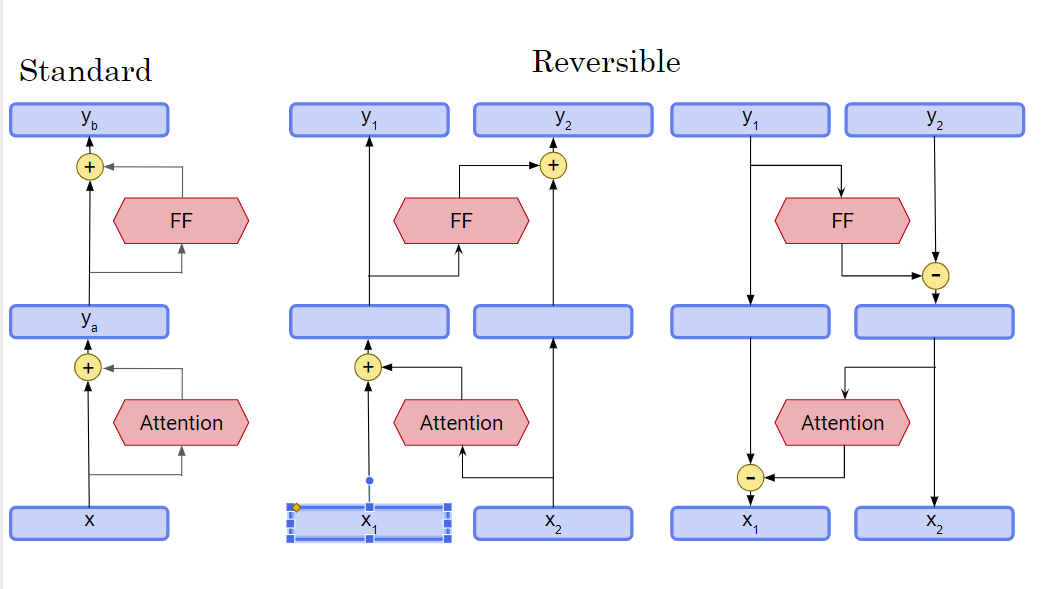</body></html>
<img src="images/reversible2.PNG" height="400" width="600">

This is how the residual networks are implemented in the standard Transformer. It follows that, given `F()` is Attention and `G()` is Feed-forward(FF). 
: 

\begin{align}  
\mathrm{y}_\mathrm{a} &= \mathrm{x} + \mathrm{F}\left(\mathrm{x}\right)\tag{1} \\
\mathrm{y}_{b}&=\mathrm{y}_{a}+\mathrm{G}\left(\mathrm{y}_{a}\right)\tag{2}\\
\end{align}


As you can see, it requires that $\mathrm{x}$ and $\mathrm{y}_{a}$ be saved so it can be used during backpropagation. We want to avoid this to conserve memory and this is where reversible residual connections come in. They are shown in the middle and rightmost diagrams above. The key idea is that we will start with two copies of the input to the model and at each layer we will only update one of them. The activations that we *don’t* update are the ones that will be used to compute the residuals. 

Now in this reversible set up you get the following instead: 

\begin{align}  
\mathrm{y}_{1}&=\mathrm{x}_{1}+\mathrm{F}\left(\mathrm{x}_{2}\right)\tag{3}\\
\mathrm{y}_{2}&=\mathrm{x}_{2}+\mathrm{G}\left(\mathrm{y}_{1}\right)\tag{4}\\
\end{align}
To recover $\mathrm{(x_1,x_2)}$ from $\mathrm{(y_1, y_2)}$ 

\begin{align}  
\mathrm{x}_{2}&=\mathrm{y}_{2}-\mathrm{G}\left(\mathrm{y}_{1}\right)\tag{5}\\
\mathrm{x}_{1}&=\mathrm{y}_{1}-\mathrm{F}\left(\mathrm{x}_{2}\right)\tag{6}\\
\end{align}

With this configuration, we’re now able to run the network fully in reverse. You'll notice that during the backward pass, $\mathrm{x2}$ and $\mathrm{x1}$ can be recomputed based solely on the values of $\mathrm{y2}$ and $\mathrm{y1}$. No need to save it during the forward pass.

<a name="ex02"></a>
### Exercise 02
**Instructions:** You will implement the `reversible_layer_forward` function using equations 3 and 4 above. This function takes in the input vector `x` and the functions `f` and `g` and returns the concatenation of $y_1 and y_2$. For this exercise, we will be splitting `x` before going through the reversible residual steps$\mathrm{^1}$.  We can then use those two vectors for the `reversible_layer_reverse` function. Utilize `np.concatenate()` to form the output being careful to match the axis of the `np.split()`.

$\mathrm{^1}$*Take note that this is just for demonstrating the concept in this exercise and there are other ways of processing the input. As you'll see in the Reformer architecture later, the initial input (i.e. `x`) can instead be duplicated instead of split.*

In [41]:
# UNQ_C2
# GRADED FUNCTION: reversible_layer_forward
def reversible_layer_forward(x, f, g):
    """
    Args: 
        x (np.array): an input vector or matrix
        f (function): a function which operates on a vector/matrix
        g (function): a function which operates on a vector/matrix
    Returns: 
        y (np.array): an output vector or matrix whose form is determined by 'x', f and g
    """
    # split the input vector into two (* along the last axis because it is the depth dimension)
    
    x1, x2 = np.split(x, 2, axis=-1) 
    
    ### START CODE HERE ###
    
    # get y1 using equation 3
    y1 = x1 + f(x2)
    
    # get y2 using equation 4
    y2 = x2 + g(y1)
    
    # concatenate y1 and y2 along the depth dimension. be sure output is of type np.ndarray
    y = np.concatenate([y1, y2], axis=-1)
    
    
    ### END CODE HERE ### 
    return y

In [42]:
# BEGIN UNIT TEST
w4_unittest.test_reversible_layer_forward(reversible_layer_forward)
# END UNIT TEST

 All tests passed


<a name="ex03"></a>
### Exercise 03

You will now implement the `reversible_layer_reverse` function  which is possible because at every time step you have $x_1$ and $x_2$ and $y_2$ and $y_1$, along with the function `f`, and `g`. Where `f` is the attention and `g` is the feedforward. This allows you to compute equations 5 and 6.


**Instructions:** Implement the `reversible_layer_reverse`. Your function takes in the output vector from  `reversible_layer_forward` and functions f and g. Using equations 5 and 6 above, it computes the inputs to the layer,  $x_1$ and $x_2$.  The output, x, is the concatenation of  $x_1, x_2$. Utilize `np.concatenate()`  to form the output being careful to match the axis of the `np.split()`.

In [43]:
# UNQ_C3
# GRADED FUNCTION: reversible_layer_reverse
def reversible_layer_reverse(y, f, g):
    """
    Args: 
        y (np.array): an input vector or matrix
        f (function): a function which operates on a vector/matrix of the form of 'y'
        g (function): a function which operates on a vector/matrix of the form of 'y'
    Returns: 
        y (np.array): an output vector or matrix whose form is determined by 'y', f and g
    """
    
    # split the input vector into two (* along the last axis because it is the depth dimension)
    y1, y2 = np.split(y, 2, axis=-1)
    
    ### START CODE HERE ###
    
    # compute x2 using equation 5
    x2 = y2 - g(y1)
    
    # compute x1 using equation 6
    x1 = y1 - f(x2)
    
    # concatenate y1 and y2 along the depth dimension
    x = np.concatenate([x1, x2], axis=-1)
    
    ### END CODE HERE ### 
    return x


In [44]:
# UNIT TEST
f = lambda x: x + 2
g = lambda x: x * 3
input_vector = np.random.uniform(size=(32,))

output_vector = reversible_layer_forward(input_vector, f, g)
reversed_vector = reversible_layer_reverse(output_vector, f, g)

assert np.allclose(reversed_vector, input_vector)

In [45]:
# BEGIN UNIT TEST
w4_unittest.test_reversible_layer_reverse(reversible_layer_reverse)
# END UNIT TEST

 All tests passed


<a name="3.1"></a>
## 3.1   Reversible layers and randomness

This is why we were learning about fastmath's random functions and keys in Course 3 Week 1. Utilizing the same key, `trax.fastmath.random.uniform()` will return the same values. This is required for the backward pass to return the correct layer inputs when random noise is introduced in the layer.

In [46]:
# Layers like dropout have noise, so let's simulate it here:
f = lambda x: x + np.random.uniform(size=x.shape)

# See that the above doesn't work any more:
output_vector = reversible_layer_forward(input_vector, f, g)
reversed_vector = reversible_layer_reverse(output_vector, f, g)

assert not np.allclose(reversed_vector, input_vector)  # Fails!!

# It failed because the noise when reversing used a different random seed.

random_seed = 27686
rng = trax.fastmath.random.get_prng(random_seed)
f = lambda x: x + trax.fastmath.random.uniform(key=rng, shape=x.shape)

# See that it works now as the same rng is used on forward and reverse.
output_vector = reversible_layer_forward(input_vector, f, g)
reversed_vector = reversible_layer_reverse(output_vector, f, g)

assert np.allclose(reversed_vector, input_vector,  atol=1e-07) 

<a name="4"></a>
# Part 4:   ReformerLM Training

You will now proceed to training your model. Since you have already know the two main components that differentiates it from the standard Transformer, LSH in Course 1 and reversible layers above, you can just use the pre-built model already implemented in Trax. It will have this architecture:
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>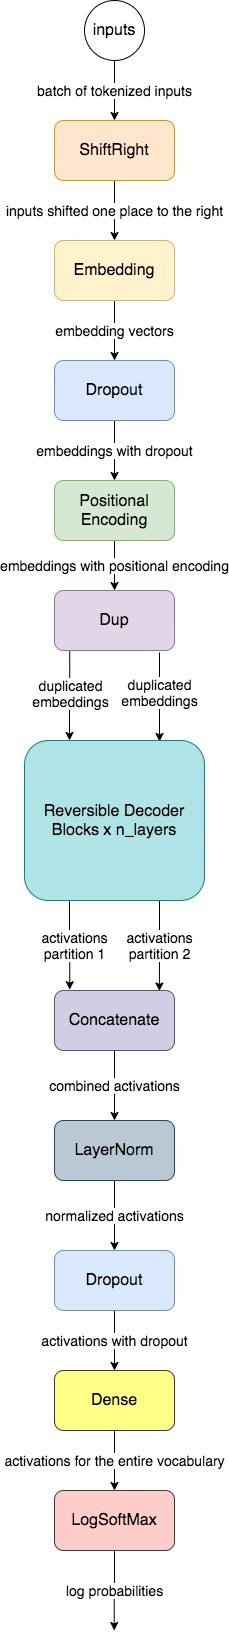</body></html>
<img src='images/Reformer.jpg'>

Similar to the Transformer you learned earlier, you want to apply an attention and feed forward layer to your inputs. For the Reformer, we improve the memory efficiency by using **reversible decoder blocks** and you can picture its implementation in Trax like below:

<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>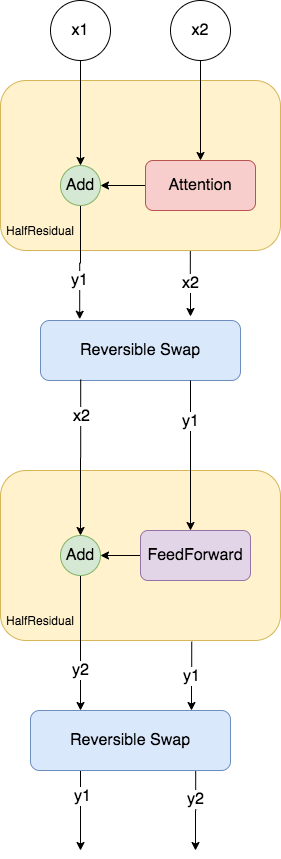</body></html>
<img src='images/ReversibleDecoder.png'>

You can see that it takes the initial inputs `x1` and `x2` and does the first equation of the reversible networks you learned in Part 3. As you've also learned, the reversible residual has two equations for the forward-pass so doing just one of them will just constitute half of the reversible decoder block. Before doing the second equation (i.e. second half of the reversible residual), it first needs to swap the elements to take into account the stack semantics in Trax. It simply puts `x2` on top of the stack so it can be fed to the add block of the half-residual layer. It then swaps the two outputs again so it can be fed to the next layer of the network. All of these arrives at the two equations in Part 3 and it can be used to recompute the activations during the backward pass.

These are already implemented for you in Trax and in the following exercise, you'll get to practice how to call them to build your network.

<a name="ex04"></a>
### Exercise 04
**Instructions:** Implement a wrapper function that returns a Reformer Language Model. You can use Trax's [ReformerLM](https://trax-ml.readthedocs.io/en/latest/trax.models.html#trax.models.reformer.reformer.ReformerLM) to do this quickly. It will have the same architecture as shown above.

In [47]:
# UNQ_C4
# GRADED FUNCTION
def ReformerLM(vocab_size=33000, n_layers=2, mode='train', attention_type=tl.SelfAttention):
    
    ### START CODE HERE ###
    # initialize an instance of Trax's ReformerLM class
    model = tl.Serial( 
                trax.models.reformer.ReformerLM( 
                # set vocab size
                vocab_size=vocab_size,
                # set number of layers
                n_layers=n_layers,
                # set mode
                mode=mode,
                # set attention type
                attention_type=attention_type
            )
            , tl.LogSoftmax() 
        )        
    ### END CODE HERE ###
    return model # tl.Serial(model, tl.LogSoftmax(),)

In [48]:
# display the model
temp_model = ReformerLM('train')
print(str(temp_model))

# free memory
#del temp_model 

Serial[
  Serial[
    Serial[
      ShiftRight(1)
    ]
    Embedding_train_512
    Dropout
    Serial[
      PositionalEncoding
    ]
    Dup_out2
    ReversibleSerial_in2_out2[
      ReversibleHalfResidualDecoderAttn_in2_out2[
        Serial[
          LayerNorm
        ]
        SelfAttention
      ]
      ReversibleSwap_in2_out2
      ReversibleHalfResidualDecoderFF_in2_out2[
        Serial[
          LayerNorm
          Dense_2048
          Dropout
          Serial[
            FastGelu
          ]
          Dense_512
          Dropout
        ]
      ]
      ReversibleSwap_in2_out2
      ReversibleHalfResidualDecoderAttn_in2_out2[
        Serial[
          LayerNorm
        ]
        SelfAttention
      ]
      ReversibleSwap_in2_out2
      ReversibleHalfResidualDecoderFF_in2_out2[
        Serial[
          LayerNorm
          Dense_2048
          Dropout
          Serial[
            FastGelu
          ]
          Dense_512
          Dropout
        ]
      ]
      ReversibleSwa

In [49]:
# BEGIN UNIT TEST
w4_unittest.test_ReformerLM(ReformerLM)
# END UNIT TEST

 All tests passed


<a name="ex05"></a>
### Exercise 05
You will now write a function that takes in your model and trains it. 

**Instructions:** Implement the `training_loop` below to train the neural network above. Here is a list of things you should do:

- Create `TrainTask` and `EvalTask`
- Create the training loop `trax.supervised.training.Loop`
- Pass in the following depending to train_task :
    - `labeled_data=train_gen`
    - `loss_layer=tl.CrossEntropyLoss()`
    - `optimizer=trax.optimizers.Adam(0.01)`
    - `lr_schedule=lr_schedule`
    - `n_steps_per_checkpoint=10`  

You will be using your CrossEntropyLoss loss function with Adam optimizer. Please read the [trax](https://trax-ml.readthedocs.io/en/latest/trax.optimizers.html?highlight=adam#trax.optimizers.adam.Adam) documentation to get a full understanding. 

- Pass in the following to eval_task:
     - `labeled_data=eval_gen`
     - `metrics=[tl.CrossEntropyLoss(), tl.Accuracy()]`



This function should return a `training.Loop` object. To read more about this check the [docs](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html?highlight=loop#trax.supervised.training.Loop).

In [50]:
# UNQ_C5
# GRADED FUNCTION: train_model
def training_loop(ReformerLM, train_gen, eval_gen, output_dir = "./model/"):
    """
    Args:
        ReformerLM:  the Reformer language model you are building
        train_gen (generator): train data generator.
        eval_gen (generator): Validation generator. 
        output_dir (string): Path to save the model output. Defaults to './model/'.

    Returns:
        trax.supervised.training.Loop: Training loop for the model.
    """

    # use the warmup_and_rsqrt_decay learning rate schedule
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(
        n_warmup_steps=1000, max_value=0.01)

    ### START CODE HERE ###
    
    # define the train task
    train_task = training.TrainTask(            
        # labeled data
        labeled_data=train_gen,
        # loss layer
        loss_layer=tl.CrossEntropyLoss(),
        # optimizer
        optimizer=trax.optimizers.Adam(0.01),
        # lr_schedule
        lr_schedule=lr_schedule,
        # n_steps
        n_steps_per_checkpoint=10 
    )

    # define the eval task
    eval_task = training.EvalTask(                      
        # labeled data
        labeled_data=eval_gen,
        # metrics
        metrics=[tl.CrossEntropyLoss(), tl.Accuracy()]
    )

    ### END CODE HERE ###
    loop = training.Loop(ReformerLM(mode='train'),
                         train_task,
                         eval_tasks=[eval_task],
                         output_dir=output_dir)
    return loop

In [51]:
# UNIT TEST COMMENT: Use the train task and eval task for grading train_model
test_loop = training_loop(ReformerLM, train_stream, eval_stream)
train_task = test_loop._tasks
eval_task = test_loop._eval_tasks

print(train_task)
print(eval_task)

In [52]:
# BEGIN UNIT TEST
w4_unittest.test_tasks(test_loop)
# END UNIT TEST

 All tests passed


In [53]:
# we will now test your function
!rm -f model/model.pkl.gz
loop = training_loop(ReformerLM, train_stream, eval_stream)
loop.run(10)


Step      1: Total number of trainable weights: 58072296
Step      1: Ran 1 train steps in 58.45 secs
Step      1: train CrossEntropyLoss |  10.43880653
Step      1: eval  CrossEntropyLoss |  10.42534065
Step      1: eval          Accuracy |  0.00000000

Step     10: Ran 9 train steps in 134.20 secs
Step     10: train CrossEntropyLoss |  10.21555233
Step     10: eval  CrossEntropyLoss |  9.78438950
Step     10: eval          Accuracy |  0.05907906


**Approximate Expected output:**  

```

Step      1: Ran 1 train steps in 55.73 secs
Step      1: train CrossEntropyLoss |  10.41907787
Step      1: eval  CrossEntropyLoss |  10.41005802
Step      1: eval          Accuracy |  0.00000000

Step     10: Ran 9 train steps in 108.21 secs
Step     10: train CrossEntropyLoss |  10.15449715
Step     10: eval  CrossEntropyLoss |  9.63478279
Step     10: eval          Accuracy |  0.16350447
``` 

<a name="5"></a>
# Part 5:   Decode from a pretrained model

We will now proceed on decoding using the model architecture you just implemented. As in the previous weeks, we will be giving you a pretrained model so you can observe meaningful output during inference. You will be using the [autoregressive_sample_stream()](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.decoding.autoregressive_sample_stream) decoding method from Trax to do fast inference. Let's define a few parameters to initialize our model.

In [54]:
# define the `predict_mem_len` and `predict_drop_len` of tl.SelfAttention
def attention(*args, **kwargs):
    # number of input positions to remember in a cache when doing fast inference. 
    kwargs['predict_mem_len'] = 120
    # number of input elements to drop once the fast inference input cache fills up.
    kwargs['predict_drop_len'] = 120
    # return the attention layer with the parameters defined above
    return tl.SelfAttention(*args, **kwargs)

# define the model using the ReformerLM function you implemented earlier.
model = ReformerLM(
    vocab_size=33000,
    n_layers=6,
    mode='predict',
    attention_type=attention,
)

# define an input signature so we can initialize our model. shape will be (1, 1) and the data type is int32.
shape11 = trax.shapes.ShapeDtype((1, 1), dtype=np.int32)

We can now initialize our model from a file containing the pretrained weights. We will save this starting state so we can reset the model state when we generate a new conversation. This will become clearer in the `generate_dialogue()` function later.

In [55]:
# initialize from file
model.init_from_file('chatbot_model1.pkl.gz',
                     weights_only=True, input_signature=shape11)

# save the starting state
STARTING_STATE = model.state

Let's define a few utility functions as well to help us tokenize and detokenize. We can use the [tokenize()](https://trax-ml.readthedocs.io/en/latest/trax.data.html#trax.data.tf_inputs.tokenize) and [detokenize()](https://trax-ml.readthedocs.io/en/latest/trax.data.html#trax.data.tf_inputs.detokenize) from `trax.data.tf_inputs` to do this.

In [56]:
def tokenize(sentence, vocab_file, vocab_dir):
    return list(trax.data.tokenize(iter([sentence]), vocab_file=vocab_file, vocab_dir=vocab_dir))[0]

def detokenize(tokens, vocab_file, vocab_dir):
    return trax.data.detokenize(tokens, vocab_file=vocab_file, vocab_dir=vocab_dir)

We are now ready to define our decoding function. This will return a generator that yields that next symbol output by the model. It will be able to predict the next words by just feeding it a starting sentence.

<a name="ex06"></a>
### Exercise 06
**Instructions:** Implement the function below to return a generator that predicts the next word of the conversation.

In [57]:
# UNQ_C6
# GRADED FUNCTION
def ReformerLM_output_gen(ReformerLM, start_sentence, vocab_file, vocab_dir, temperature, tokenize=tokenize):
    """
    Args:
        ReformerLM:  the Reformer language model you just trained
        start_sentence (string): starting sentence of the conversation
        vocab_file (string): vocabulary filename
        vocab_dir (string): directory of the vocabulary file
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)

    Returns:
        generator: yields the next symbol generated by the model
    """
    
    ### START CODE HERE ###
    
    # Create input tokens using the the tokenize function
    input_tokens = tokenize(start_sentence, vocab_file=vocab_file, vocab_dir=vocab_dir)
    
    # Add batch dimension to array. Convert from (n,) to (1, n)
    input_tokens_with_batch = np.array(input_tokens)[None, :]
    
    # call the autoregressive_sample_stream function from trax
    output_gen = trax.supervised.decoding.autoregressive_sample_stream( 
        # model
        ReformerLM,
        # inputs will be the tokens with batch dimension
        inputs=input_tokens_with_batch,
        # temperature
        temperature=temperature
    )
    
    ### END CODE HERE ###
    
    return output_gen

In [65]:
## BEGIN UNIT TEST
test_model = ReformerLM(vocab_size=5, n_layers=1, mode='predict', attention_type=attention)
test_output_gen = ReformerLM_output_gen(test_model, "test", vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR, temperature=0)

w4_unittest.test_ReformerLM_output_gen(test_model, test_output_gen)
del test_model, test_output_gen
# END UNIT TEST

<generator object autoregressive_sample_stream at 0x7fb41c11a0d0>
Generated output [DeviceArray(1, dtype=int32), DeviceArray(0, dtype=int32), DeviceArray(4, dtype=int32), DeviceArray(3, dtype=int32), DeviceArray(0, dtype=int32), DeviceArray(4, dtype=int32)]
 All tests passed


# ***Expected value:***

```
[DeviceArray(1, dtype=int32), DeviceArray(0, dtype=int32), DeviceArray(4, dtype=int32), DeviceArray(3, dtype=int32), DeviceArray(0, dtype=int32), DeviceArray(4, dtype=int32)]
```

Great! Now you will be able to see the model in action. The utility function below will call the generator you just implemented and will just format the output to be easier to read. 

In [59]:
shape11 = trax.shapes.ShapeDtype((1, 1), dtype=np.int32)

def attention(*args, **kwargs):
    kwargs['predict_mem_len'] = 120  # max length for predictions
    kwargs['predict_drop_len'] = 120  # never drop old stuff
    return tl.SelfAttention(*args, **kwargs)

model = ReformerLM(
    vocab_size=33000,
    n_layers=6,
    mode='predict',
    attention_type=attention,
)

In [60]:
model.init_from_file('chatbot_model1.pkl.gz',
                     weights_only=True, input_signature=shape11)

STARTING_STATE = model.state

In [61]:
def generate_dialogue(ReformerLM, model_state, start_sentence, vocab_file, vocab_dir, max_len, temperature):
    """
    Args:
        ReformerLM:  the Reformer language model you just trained
        model_state (np.array): initial state of the model before decoding
        start_sentence (string): starting sentence of the conversation
        vocab_file (string): vocabulary filename
        vocab_dir (string): directory of the vocabulary file
        max_len (int): maximum number of tokens to generate 
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)

    Returns:
        generator: yields the next symbol generated by the model
    """  
    
    # define the delimiters we used during training
    delimiter_1 = 'Person 1: ' 
    delimiter_2 = 'Person 2: '
    
    # initialize detokenized output
    sentence = ''
    
    # token counter
    counter = 0
    
    # output tokens. we insert a ': ' for formatting
    result = [tokenize(': ', vocab_file=vocab_file, vocab_dir=vocab_dir)]
    
    # reset the model state when starting a new dialogue
    ReformerLM.state = model_state
    
    # calls the output generator implemented earlier
    output = ReformerLM_output_gen(ReformerLM, start_sentence, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR, temperature=temperature)
    
    # print the starting sentence
    print(start_sentence.split(delimiter_2)[0].strip())
    
    # loop below yields the next tokens until max_len is reached. the if-elif is just for prettifying the output.
    for o in output:
        
        result.append(o)
        
        sentence = detokenize(np.concatenate(result, axis=0), vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)
        
        if sentence.endswith(delimiter_1):
            sentence = sentence.split(delimiter_1)[0]
            print(f'{delimiter_2}{sentence}')
            sentence = ''
            result.clear()
        
        elif sentence.endswith(delimiter_2):
            sentence = sentence.split(delimiter_2)[0]
            print(f'{delimiter_1}{sentence}')
            sentence = ''
            result.clear()

        counter += 1
        
        if counter > max_len:
            break    

We can now feed in different starting sentences and see how the model generates the dialogue. You can even input your own starting sentence. Just remember to ask a question that covers the topics in the Multiwoz dataset so you can generate a meaningful conversation.

In [62]:
sample_sentence = ' Person 1: Are there theatres in town? Person 2: '
generate_dialogue(ReformerLM=model, model_state=STARTING_STATE, start_sentence=sample_sentence, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR, max_len=120, temperature=0.2)

Person 1: Are there theatres in town?
Person 2: : There are 4 theatres in town. Do you have a preference? 
Person 1: Not really, can you recommend one and give me the phone number, postcode, and entrance fee please. 
Person 2: I would recommend the mumford theatre. The postcode is cb11pt. The phone number is 08451962320. 
Person 1: Thank you. I also need a train to Cambridge. 


In [63]:
sample_sentence = ' Person 1: Is there a hospital nearby? Person 2: '
generate_dialogue(ReformerLM=model, model_state=STARTING_STATE, start_sentence=sample_sentence, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR, max_len=120, temperature=0.2)

Person 1: Is there a hospital nearby?
Person 2: : Addensbrookes Hospital is located at Hills Rd, Cambridge, Postcode CB20QQ. Do you need the phone number? 
Person 1: No, that's all I needed. Thank you. 
Person 2: You're welcome. Have a good day.The main phone number is 01223245151. 
Person 1: Thank you for your help. 
Person 2: You're welcome. Have a good day.


In [64]:
sample_sentence = ' Person 1: Can you book a taxi? Person 2: '
generate_dialogue(ReformerLM=model, model_state=STARTING_STATE, start_sentence=sample_sentence, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR, max_len=120, temperature=0.2)

Person 1: Can you book a taxi?
Person 2: : I sure can. When would you like to leave? 
Person 1: I need to leave after 21:45. 
Person 2: I can help with that. Where are you going? 
Person 1: I'm going to be going to be from the city stop restaurant. 
Person 2: I have booked you a taxi. It is a grey Volkswagen. The contact number is 07750608995. 
Person 1: Thank you very much. 


**Congratulations! You just wrapped up the final assignment of this course and the entire specialization!**